## SimpleITK.ipynb

This file is a proof of concept of using SimpleITK to work with the sample data (NRRD and NIfTI formats).

Code is based on the [SimpleITK tutorial notebooks](https://github.com/SimpleITK/TUTORIAL), with some **setup instructions** [here](https://simpleitk.org/TUTORIAL/) (update Anaconda, and **download default external image viewer** [Fiji](https://fiji.sc/#download)).

I believe the image files all contain one color channel.

Some images here are displayed inline using `matplotlib`, which displays color (even though there should be only one color channel). By contrast, the external viewer Fiji displays in black and white (which is what we'd like to put in the GUI or use for midterm presentation screenshots). Fiji also gives you a slider for changing the z slice to be displayed.

If you just need a few screenshots and don't need rotations for your work (e.g., GUI or midterm presentation), then open the image in Fiji (explained below) since it's easy. For displaying rotated images inline, I use `matplotlib`. We can also export rotated images to `jpg`, `png`, etc. (see below).

Run in VSCode or Anaconda (`jupyter notebook` command).

TODO: Cite the SimpleITK repo if borrowing their code

Note $_1$: The SimpleITK tutorial is **very** in-depth and covers **a lot** of stuff that I don't think we'll need. The basic stuff here should be most of what we need for this project. The [tutorial repo](https://github.com/SimpleITK/tutorial) has notebooks 0-10. I have not looked closely at notebooks 3-10, but based on their names, I don't think we have a use for them.

Note $_2$: SimpleITK image dimensions are `(x, y, z)`, whereas `numpy`'s are `(z, y, x)`. 😔 But don't think we'll end up using `numpy` much, if at all, so this is not a huge concern.

I used [this](https://discourse.itk.org/t/simpleitk-euler3d-transform-problem-with-output-size-resampling/4387) for the 3D transform

In [1]:
!pip3 install SimpleITK

import sys

print(sys.executable)

import SimpleITK as sitk
import numpy as np

%matplotlib inline


# For displaying images inline
import matplotlib.pyplot as plt

# For interactive sliders that allow you to rotate the images displayed in this file
from ipywidgets import interact, fixed

OUTPUT_DIR = "output"
# The default image viewer is the Fiji program. It could be changed to other programs
image_viewer = sitk.ImageViewer()

/Users/jesse/.pyenv/versions/3.10.2/bin/python


## Get Image from NRRD file (`.nrrd`), store in `nrrd_image`

### `image_viewer.Execute(nrrd_image)` will open the 3D image in Fiji, and you can use a slider to change the z slice there. You need to have Fiji installed for this. I commented it out because it takes a while to boot. If you want to use Fiji, uncomment it.

In [2]:
nrrd_reader = sitk.ImageFileReader()
# The ImageFileReader can automatically detect which ImageIO to use so the below line is not needed.
# nrrd_reader.SetImageIO("NrrdImageIO")

nrrd_reader.SetFileName("../../ExampleData/BCP_Dataset_2month_T1w.nrrd")
nrrd_image = nrrd_reader.Execute()

# image_viewer.Execute(nrrd_image)

## Get image from NIfTI file (.nii.gz or .nii), store in `nifti_image`

In [3]:
nifti_reader = sitk.ImageFileReader()
nifti_reader.SetFileName("../../ExampleData/MicroBiome_1month_T1w.nii.gz")
nifti_image = nifti_reader.Execute()

# image_viewer.Execute(nifti_image)

## Get 2D slice of 3D image using Python slicing, display it inline using `matplotlib`


dimensions (x, y, z): (195, 233, 159)
pixel ID type: <bound method Image.GetPixelIDTypeAsString of <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x1053f2880> >>


(-0.5, 194.5, 232.5, -0.5)

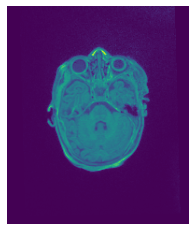

In [4]:
dimensions = nrrd_image.GetSize()
print(f"dimensions (x, y, z): {dimensions}")
print(f"pixel ID type: {nrrd_image.GetPixelIDTypeAsString}")

nrrd_slice = nrrd_image[:, :, 48]

plt.imshow(sitk.GetArrayViewFromImage(nrrd_slice))
plt.axis("off")

`matplotlib` displays in color, which is weird. Display the slice in Fiji to confirm that `nrrd_slice` hasn't been mutated and it's just that `matplotlib` displays the image differently from Fiji does.

Indeed, Fiji displays in greyscale so the image hasn't been mutated. I think the nrrd and NIfTI have only one color channel, it's just that `matplotlib` displays displays color with the one color channel

In [5]:
# image_viewer.Execute(nrrd_slice)

### Do a 3D rotation on a `.nrrd` using `Euler3DTransform` and display a slice with `interact`ive widgets

### Note, if we have only one transform for 3 images, then modifying one transform will modify for the other 3 (i.e., reference type). So I use 3 `Euler3DTransform`s. This needs to be considered for batch processing with multiple images.

In [6]:
def resample_display3D_xslice(
    image, euler3d_transform, theta_x, theta_y, theta_z, slice_x
):
    euler3d_transform.SetRotation(theta_x, theta_y, theta_z)
    resampled_image = sitk.Resample(image, euler3d_transform)
    resampled_image_slice = resampled_image[slice_x, :, :]

    plt.imshow(sitk.GetArrayFromImage(resampled_image_slice))
    plt.axis("off")
    plt.show()


def resample_display3D_yslice(
    image, euler3d_transform, theta_x, theta_y, theta_z, slice_y
):
    euler3d_transform.SetRotation(theta_x, theta_y, theta_z)
    resampled_image = sitk.Resample(image, euler3d_transform)
    resampled_image_slice = resampled_image[:, slice_y, :]

    plt.imshow(sitk.GetArrayFromImage(resampled_image_slice))
    plt.axis("off")
    plt.show()


def resample_display3D_zslice(
    image, euler3d_transform, theta_x, theta_y, theta_z, slice_z
):
    euler3d_transform.SetRotation(theta_x, theta_y, theta_z)
    resampled_image = sitk.Resample(image, euler3d_transform)
    resampled_image_slice = resampled_image[:, :, slice_z]

    plt.imshow(sitk.GetArrayFromImage(resampled_image_slice))
    plt.axis("off")
    plt.show()


theta_x = 0
theta_y = 0
theta_z = 0
euler3d_x_nrrd = sitk.Euler3DTransform(
    nrrd_image.TransformContinuousIndexToPhysicalPoint(
        [(sz - 1 / 2.0) for sz in nrrd_image.GetSize()]
    ),
    theta_x,
    theta_y,
    theta_z,
)
euler3d_y_nrrd = sitk.Euler3DTransform(
    nrrd_image.TransformContinuousIndexToPhysicalPoint(
        [(sz - 1 / 2.0) for sz in nrrd_image.GetSize()]
    ),
    theta_x,
    theta_y,
    theta_z,
)
euler3d_z_nrrd = sitk.Euler3DTransform(
    nrrd_image.TransformContinuousIndexToPhysicalPoint(
        [(sz - 1 / 2.0) for sz in nrrd_image.GetSize()]
    ),
    theta_x,
    theta_y,
    theta_z,
)

interact(
    resample_display3D_xslice,
    image=fixed(nrrd_image),
    euler3d_transform=fixed(euler3d_x_nrrd),
    theta_x=(-np.pi, np.pi),
    theta_y=(-np.pi, np.pi),
    theta_z=(-np.pi, np.pi),
    slice_x=(0, nrrd_image.GetSize()[0] - 1),
)

interact(
    resample_display3D_yslice,
    image=fixed(nrrd_image),
    euler3d_transform=fixed(euler3d_y_nrrd),
    theta_x=(-np.pi, np.pi),
    theta_y=(-np.pi, np.pi),
    theta_z=(-np.pi, np.pi),
    slice_y=(0, nrrd_image.GetSize()[1] - 1),
)

interact(
    resample_display3D_zslice,
    image=fixed(nrrd_image),
    euler3d_transform=fixed(euler3d_z_nrrd),
    theta_x=(-np.pi, np.pi),
    theta_y=(-np.pi, np.pi),
    theta_z=(-np.pi, np.pi),
    slice_z=(0, nrrd_image.GetSize()[2] - 1),
)

interactive(children=(FloatSlider(value=0.0, description='theta_x', max=3.141592653589793, min=-3.141592653589…

interactive(children=(FloatSlider(value=0.0, description='theta_x', max=3.141592653589793, min=-3.141592653589…

interactive(children=(FloatSlider(value=0.0, description='theta_x', max=3.141592653589793, min=-3.141592653589…

<function __main__.resample_display3D_zslice(image, euler3d_transform, theta_x, theta_y, theta_z, slice_z)>

### Do the same thing with `nifti_image` to confirm it works for NIfTI also

In [7]:
theta_x = 0
theta_y = 0
theta_z = 0
euler3d_x_nifti = sitk.Euler3DTransform(
    nrrd_image.TransformContinuousIndexToPhysicalPoint(
        [(sz - 1 / 2.0) for sz in nifti_image.GetSize()]
    ),
    theta_x,
    theta_y,
    theta_z,
)
euler3d_y_nifti = sitk.Euler3DTransform(
    nrrd_image.TransformContinuousIndexToPhysicalPoint(
        [(sz - 1 / 2.0) for sz in nifti_image.GetSize()]
    ),
    theta_x,
    theta_y,
    theta_z,
)
euler3d_z_nifti = sitk.Euler3DTransform(
    nrrd_image.TransformContinuousIndexToPhysicalPoint(
        [(sz - 1 / 2.0) for sz in nifti_image.GetSize()]
    ),
    theta_x,
    theta_y,
    theta_z,
)


interact(
    resample_display3D_xslice,
    image=fixed(nifti_image),
    euler3d_transform=fixed(euler3d_x_nifti),
    theta_x=(-np.pi, np.pi),
    theta_y=(-np.pi, np.pi),
    theta_z=(-np.pi, np.pi),
    # Subtract 1 because 0-indexed
    slice_x=(0, nifti_image.GetSize()[0] - 1),
)

interact(
    resample_display3D_yslice,
    image=fixed(nifti_image),
    euler3d_transform=fixed(euler3d_y_nifti),
    theta_x=(-np.pi, np.pi),
    theta_y=(-np.pi, np.pi),
    theta_z=(-np.pi, np.pi),
    # Subtract 1 because 0-indexed
    slice_y=(0, nifti_image.GetSize()[1] - 1),
)

interact(
    resample_display3D_zslice,
    image=fixed(nifti_image),
    euler3d_transform=fixed(euler3d_z_nifti),
    theta_x=(-np.pi, np.pi),
    theta_y=(-np.pi, np.pi),
    theta_z=(-np.pi, np.pi),
    # Subtract 1 because 0-indexed
    slice_z=(0, nifti_image.GetSize()[2] - 1),
)

interactive(children=(FloatSlider(value=0.0, description='theta_x', max=3.141592653589793, min=-3.141592653589…

interactive(children=(FloatSlider(value=0.0, description='theta_x', max=3.141592653589793, min=-3.141592653589…

interactive(children=(FloatSlider(value=0.0, description='theta_x', max=3.141592653589793, min=-3.141592653589…

<function __main__.resample_display3D_zslice(image, euler3d_transform, theta_x, theta_y, theta_z, slice_z)>

### Export a 2D slice (x, y, or z (default z)) to JPG or some other format

In [8]:
def rotate_and_export_slice(
    sitk_3Dimg,
    theta_x: float,
    theta_y: float,
    theta_z: float,
    slice_num: int,
    filename: str,
    **kwargs,
) -> None:
    """Rotate 3D image, export 2D slice.

    Parameters
    ----------
    sitk_3Dimg
        Result of sitk.ImageFileReader().Execute()
    theta_x, theta_y, theta_z
        Give angles in degrees
    slice_num
        Number of the slice
    filename
        Give extension also
    **kwargs
        'axis'
            'x', 'y', or 'z', defaults to 'z'
    """
    if "axis" in kwargs and kwargs["axis"].lower() not in {"x", "y", "z"}:
        raise Exception(f"Invalid axis {kwargs['axis']} specified. Use 'x', 'y', 'z'.")
    # Create new Euler3DTransform for sitk_img because if there are multiple images, they need multiple Euler3DTransforms
    # Center of rotation is center of the 3D image
    euler_3d_transform = sitk.Euler3DTransform(
        sitk_3Dimg.TransformContinuousIndexToPhysicalPoint(
            [(sz - 1 / 2.0) for sz in sitk_3Dimg.GetSize()]
        )
    )
    euler_3d_transform.SetRotation(
        theta_x * np.pi / 180, theta_y * np.pi / 180, theta_z * np.pi / 180
    )
    rotated_img = sitk.Resample(sitk_3Dimg, euler_3d_transform)

    axis = kwargs["axis"] if "axis" in kwargs else "z"
    slice = (
        rotated_img[:, :, slice_num]
        if axis == "z"
        else rotated_img[:, slice_num, :]
        if axis == "y"
        else rotated_img[slice_num, :, :]
    )
    sitk.WriteImage(slice, filename)

### JPG format

In [10]:
from PIL import Image

temp = sitk.GetArrayFromImage(nrrd_slice)

with open("arr.txt", "w") as f:
    for i in range(len(temp)):
        for j in range(len(temp[0])):
            f.write(str(temp[i][j]))

temp = ((temp - temp.min()) / (temp.max() - temp.min()) * 240).astype(np.uint8)

JPG = Image.fromarray(temp)

JPG.save("test2.jpg")